<a href="https://colab.research.google.com/github/realfolkcode/AdversarialRegularization/blob/main/filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import

In [4]:
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

Cloning into 'AdversarialRegularization'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 5), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (23/23), done.


# Loading Models

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
model_dir = 'AdversarialRegularization/models/'
model_lst = []

for model_name in os.listdir('AdversarialRegularization/models/'):
    model_path = os.path.join(model_dir, model_name)
    model = CNN(num_classes=100)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_lst.append(model)

In [10]:
model_lst[0]

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [13]:
print('Number of models:', len(model_lst))

Number of models: 2


# Filter Dataset

Let us create a class for filters dataset to make life easier. We will use it to train discriminators. As input, it would take a list of convolution layers (kernel sizes must be the same).

In [11]:
class FilterDataset(Dataset):
    def __init__(self, layer_lst):
        self.kernels = [layer.weight.data.clone() for layer in layer_lst]
        self.kernels = torch.cat(self.kernels)
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [12]:
model_lst[0].features[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [15]:
filters = FilterDataset([model_lst[0].features[0],
                         model_lst[1].features[0]])
filters_loader = DataLoader(filters, batch_size=32, shuffle=False)

In [16]:
print(f'Dataset size: {len(filters)}')

Dataset size: 384


Now, we can iterate over filters dataset.

In [17]:
for batch in filters_loader:
    print(batch)
    break

tensor([[[[ 0.0401, -0.0200, -0.0718,  ..., -0.0826,  0.0342, -0.0378],
          [ 0.1044, -0.0766, -0.1169,  ..., -0.0592,  0.0058, -0.0610],
          [ 0.0911, -0.1083, -0.0775,  ..., -0.0563,  0.0218,  0.0066],
          ...,
          [ 0.0874, -0.0691, -0.1177,  ..., -0.0543, -0.0503, -0.0523],
          [ 0.0109, -0.0114, -0.1073,  ..., -0.1392,  0.0869, -0.0065],
          [ 0.0754, -0.0351, -0.0970,  ..., -0.0819,  0.0255, -0.0347]]],


        [[[ 0.0339, -0.0580, -0.0850,  ..., -0.0621,  0.0343,  0.0472],
          [ 0.0937, -0.1505, -0.0497,  ..., -0.1150,  0.0170,  0.0345],
          [ 0.1707, -0.1868, -0.0996,  ..., -0.1053, -0.0603,  0.0110],
          ...,
          [ 0.2022, -0.2339, -0.0922,  ..., -0.1470,  0.0204,  0.0123],
          [ 0.1133, -0.1418, -0.1535,  ..., -0.1206,  0.0385,  0.0443],
          [-0.0023, -0.0106, -0.0210,  ..., -0.0967,  0.0185,  0.0037]]],


        [[[-0.0180, -0.0012,  0.0387,  ..., -0.0154,  0.0061, -0.0412],
          [-0.0107, -0.016

We can also visualize kernels to check if our dataset contains patterns.

In [18]:
def plot_kernels(loader, nrow=8):
    dataiter = iter(loader)
    batch = dataiter.next()
    rows = np.min((batch.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(batch, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

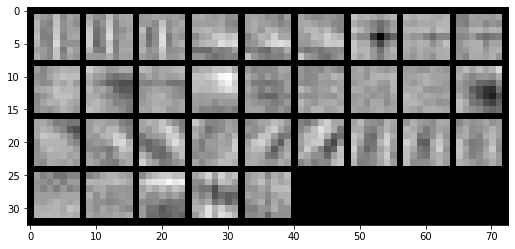

In [19]:
plot_kernels(filters_loader, nrow=9)

Indeed, filters have patterns. Moreover, kernels within the same filter appear to be correlated.

Passing `shuffle=True` to `FilterDataset` results in shuffled batches.

In [20]:
filters_loader = DataLoader(filters, batch_size=32, shuffle=True)

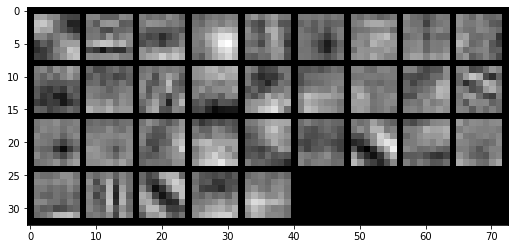

In [21]:
plot_kernels(filters_loader, nrow=9)